# Audio Scene Classification for Binaural Ensembles
## Data generation and model building

**Table of Content**

1. HRIR Preparation
    - Store all HRIR in ***hrir_array***, and store the sample rate in ***hrir_sr***
    - Print List of HRIR files, and display audio for checking
2. HRIR Vector Preparation
    - Create ***hrir_vector*** to store the azimuth and elevation of corresponding HRIR files in ***hrir_array***
3. VBAP Panner Class
    - Detailed description in the class cell


In [1]:
import vbap_utils as u

### 1. HRIR Preparation

In [ ]:
# load hrtf
hrtf_set = u.hrtf()
hrtf_set.load()

In [ ]:
# print hrtf files
hrtf_set.print_files()

In [ ]:
# play hrtf files for checking
hrtf_set.play_files()

In [ ]:
# print speaker arrays
hrtf_set.print_speaker_array()

In [ ]:
# get hrtf data
hrtf_array, hrtf_sr, hrtf_vector = hrtf_set.get()

print(hrtf_array.shape)
print(hrtf_sr)
print(hrtf_vector.shape)

### 2. Create vbap panner

In [ ]:
panner = u.vbap_panner(hrtf_array, hrtf_sr, hrtf_vector)

### 3. Generate Ensemble Locations

#### 3.0 TEST: 8 location - 1 song - 0 width - 1 track (mix)

In [2]:
import numpy as np
from IPython.display import Audio

In [ ]:
# num_examples = 1000
# center_array = np.array([0, 45, 90, 135, 180, 225, 270, 315])
# width = 0
# max_num_tracks = 1

# source_locations = u.random_generater(num_examples, center_array, width, max_num_tracks)
# print(source_locations)

#### 3.1 TEST: 8 location - 1 song - Increased width - 1 track (mix)

In [ ]:
# num_examples = 1000
# center_array = np.array([0, 45, 90, 135, 180, 225, 270, 315])
# width = 20
# max_num_tracks = 1

# source_locations = u.random_generater(num_examples, center_array, width, max_num_tracks)
# print(source_locations)

In [ ]:
# duration = 3
# sig_dir = _SOURCES[2]
# [sig, sig_sr] = sf.read(sig_dir)
# sig_truncated = sig[sig_sr*duration*3:sig_sr*duration*4 ,]

In [ ]:
# for i in range(5):
#     azi = source_locations[i][0] + source_locations[i][1]
#     ele = 0
#     print("Azimuth: " +str(azi) + ", Elevation: 0")
#     Bin_Mix = panner.spatialize(sig_truncated, sig_sr, azi, ele)
#     display(Audio(Bin_Mix.T, rate=panner.hrir_sr))

#### 3.2 TEST: 8 location - 20 song - Increased width - 1 track (mix)

In [ ]:
# preparing signals
sig_array, sig_sr = u.get_sig_array(size=160)
    
print(sig_array.shape)
print(sig_sr)
print(np.max(np.abs(sig_array)))

In [3]:
num_examples = 1000
center_array = np.array([0, 45, 90, 135, 180, 225, 270, 315])
width = 40
max_num_tracks = 1

source_locations = u.random_generater(num_examples, center_array, width, max_num_tracks)
print(source_locations)

[[135  19]
 [ 90  38]
 [225   7]
 ...
 [ 45  18]
 [225  13]
 [315  40]]


In [ ]:
for i in range(5):
    azi = source_locations[i][0] + source_locations[i][1]
    ele = 0
    print("Azimuth: " +str(azi) + ", Elevation: 0")
    Bin_Mix = panner.spatialize(sig_array[i%len(sig_array)], sig_sr, azi, ele)
    display(Audio(Bin_Mix.T, rate=panner.hrir_sr))

In [ ]:
# panner = vbap_panner(hrir_array, hrir_sr, hrir_vector)

# duration = 15
# for i in range(len(_SOURCES)):
#     sig_dir = _SOURCES[i]
#     [sig, sig_sr] = sf.read(sig_dir)
#     sig_truncated = sig[0:sig_sr*duration,]
#     print(str(i))
#     azi = i*45
#     ele = 0
#     print("Azimuth: " +str(azi) + ", Elevation: 0")
#     Bin_Mix = panner.spatialize(sig_truncated, sig_sr, azi, ele)
#     display(Audio(Bin_Mix.T, rate=panner.hrir_sr))
#     sf.write(str(i) + "_Az" +str(azi) + "_Ele0.wav",Bin_Mix,panner.hrir_sr)

### 6. Preprocessing

In [ ]:
dataset = u.generate_data(source_locations, sig_array, sig_sr, panner, size=1000)

print(dataset.shape)

In [ ]:
# np.save('./dataset/20_song_160_seg_20_width.npy', dataset)

In [5]:
dataset = np.load('./dataset/20_song_160_seg_40_width.npy')

In [6]:
print(dataset.shape)

(1000, 128, 259, 2)


### 7. Baseline Classifier: 1 conv unit - 1 dense unit

In [4]:
# Import library
# from tensorflow import keras
# from tensorflow.keras import layers
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

2023-03-07 19:02:12.073074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
# Build the model
# Define the number of classes
num_classes = 8

# Define the input shape
input_shape = (128,259,2)

# Initialize the model
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(16, (3, 3), strides=(2, 2), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

# Add the second convolutional layer
model.add(Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding="same"))

# Add the third convolutional layer
model.add(Conv2D(64, (3, 3), strides=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

# Flatten the output of the convolutional layers
model.add(Flatten())
model.add(BatchNormalization())

# Add the first dense layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Add the second dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Add the output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0006)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [40]:
# train test split, nomalize, reshape
train_size = 700
val_size = 150

features_train = dataset[:train_size]
features_val = dataset[train_size: train_size + val_size]
features_test = dataset[train_size + val_size:]

labels = source_locations[:, 0]

labels_train = labels[:train_size] / 45
labels_val = labels[train_size: train_size + val_size] / 45
labels_test = labels[train_size + val_size:] / 45

# print(labels_train)

In [41]:
# train model
# Train the model for a specified number of epochs
num_epochs = 50
batch_size = 16
callback = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=10)

history = model.fit(features_train, labels_train, epochs=num_epochs,  batch_size=batch_size, validation_data=(features_val, labels_val))

Epoch 1/50
44/44 [==============================] - 3s 59ms/step - loss: 2.4431 - accuracy: 0.1829 - val_loss: 2.2271 - val_accuracy: 0.2333
Epoch 2/50
44/44 [==============================] - 3s 63ms/step - loss: 1.8249 - accuracy: 0.3643 - val_loss: 1.9430 - val_accuracy: 0.2067
Epoch 3/50
44/44 [==============================] - 3s 63ms/step - loss: 1.6349 - accuracy: 0.3886 - val_loss: 1.8222 - val_accuracy: 0.3067
Epoch 4/50
44/44 [==============================] - 3s 58ms/step - loss: 1.5917 - accuracy: 0.3957 - val_loss: 1.8896 - val_accuracy: 0.3133
Epoch 5/50
44/44 [==============================] - 2s 56ms/step - loss: 1.4594 - accuracy: 0.4343 - val_loss: 1.8774 - val_accuracy: 0.2667
Epoch 6/50
44/44 [==============================] - 3s 58ms/step - loss: 1.3367 - accuracy: 0.4971 - val_loss: 1.9148 - val_accuracy: 0.2333
Epoch 7/50
44/44 [==============================] - 3s 66ms/step - loss: 1.3342 - accuracy: 0.4871 - val_loss: 1.9013 - val_accuracy: 0.2667
Epoch 8/50
44

In [42]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
def plot_loss(history):
    """
    Plot the training and validation loss and accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
      The history object returned by the `fit` method of a Keras model.

    Returns
    -------
    None
    """

    # Plot the training and validation loss side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the training and validation loss
    ax[0].plot(history.history['loss'], label='train')
    ax[0].plot(history.history['val_loss'], label='val')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot the training and validation accuracy
    ax[1].plot(history.history['accuracy'], label='train')
    ax[1].plot(history.history['val_accuracy'], label='val')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    

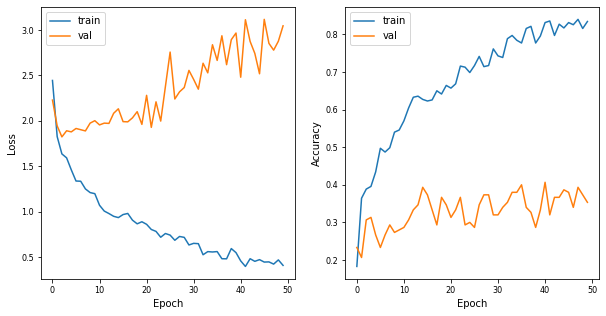

In [44]:
plot_loss(history)

In [45]:
# pridiction analysis
predictions = model.predict(features_test)
print(predictions[0])

print(labels_test[0])

print(labels_val.shape)

5/5 [==============================] - 0s 28ms/step
[9.5927835e-01 8.3971463e-06 6.0017187e-06 6.5052343e-05 6.0030989e-06
 1.5721895e-03 5.0905892e-05 3.9013136e-02]
7.0
(150,)


In [46]:
test_loss, test_acc = model.evaluate(features_test, labels_test)
print(f"test_acc: {test_acc}")

5/5 [==============================] - 0s 28ms/step - loss: 1.9689 - accuracy: 0.4467
test_acc: 0.4466666579246521


In [15]:
# model.save('./dataset/model1.0')

In [47]:
y_true = labels_test
y_pred = []
for i in range(len(predictions)):
    y_pred.append(np.argmax(predictions[i]))

print(y_true.size)


150


In [48]:
import sklearn as sk

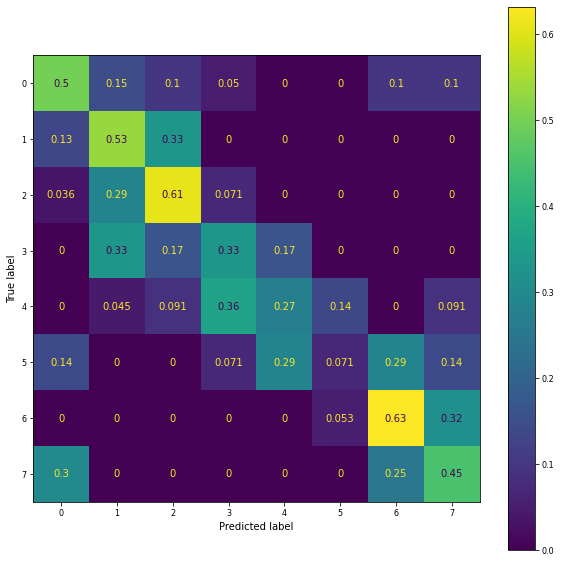

In [49]:


cm = sk.metrics.confusion_matrix(y_true, y_pred, normalize = 'true')
disp = sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)

plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
disp.plot()
fig = disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(10)  
plt.show(disp)

### Future Work
- Finish the Data Generation Pipeline
    - Input:
        - /Dataset/Examples/Stems
        - Azimuth locations ([0, 45, 90, 135, 180, 225, 270, 315])
        - Width (Location for each stem = Azimuth location +- Width/2)
    - Output
        - Binuaralized Examples
        - Location label, dimension? how to store?
- Use Slakh Library to generate a protype dataset
    - Use Mirdata?
        - Multitrack object?